# Coffea and Awkward

**March 15, 2023 at Beijing**

In [1]:
import awkward as ak
import uproot
import hist
import os
import numpy as np
# from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
# from coffea.nanoevents.methods.base import NanoEventsArray
from imp import reload #每次修改调用函数后可以更新
import correctionlib, rich
import matplotlib.pyplot as plt
import sys
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd

/tmp/ipykernel_334068/1205526036.py:8: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload #每次修改调用函数后可以更新


In [2]:
def load_event_dict(file_prefix, keys):
    data_subkeys = ['reco_photon_pt','reco_photon_eta','reco_muon1_pt','reco_muon2_pt','reco_muon1_eta','reco_muon2_eta','reco_muon_mass','reco_gmumu_mass','gen_infiducial_photon_pt','gen_infiducial_photon_eta','gen_infiducial_muon1_pt','gen_infiducial_muon2_pt','gen_infiducial_muon1_eta','gen_infiducial_muon2_eta','gen_infiducial_muon_mass','gen_infiducial_gmumu_mass','reco_photon_endcap','reco_photon_barrel','generator_weight','event_weight','GenDressedLepton','GenIsolatedPhoton','npvsGood','Rho_Calo','Rho_tracker','gen_outfiducial_photon_pt','gen_outfiducial_photon_eta','gen_outfiducial_muon1_pt','reco_outfiducial_photon_pt','reco_outfiducial_muon_mass','reco_outfiducial_photon_pt','reco_outfiducial_photon_eta','reco_outfiducial_muon1_pt','reco_outfiducial_muon2_pt','reco_outfiducial_muon1_eta','reco_outfiducial_muon2_eta','event_outfiducial_weight','outfiducial_LHEPdfWeight','outfiducial_LHEScaleWeight','outfiducial_PSWeight','outfiducial_npvsGood','outfiducial_Rho_Calo','outfiducial_Rho_tracker']
#    data_subkeys = ['photon_pt', 'photon_eta', 'muon1_pt', 'muon2_pt', 'muon1_eta', 'muon2_eta', 'muon_mass']
    other_subkeys = data_subkeys + ['generator_weight', 'event_weight']#'LHEPdfWeight','LHEScaleWeight'
    
    event_dict = {}
    for key in keys:
        subkeys = other_subkeys if 'data' not in key else data_subkeys
        event_dict[key] = {}
        for subkey in subkeys:
            event_dict[key][subkey] = ak.from_parquet(f'{file_prefix}_{key}_{subkey}.parquet')
    return event_dict

In [3]:
keys = ['zg0', 'zg1', 'zg2','zg3']  # 根据你的实际键来修改这个列表
#keys = ['zg', 'tt', 'zz', 'ww', 'wz']  # 根据你的实际键来修改这个列表
#keys = ['dataC', 'dataD']
# keys = ['zg0', 'zg1', 'zg2','zg3']
# keys = ['zg0']
# 读取数据
fiducial_final = load_event_dict('fiducial_file/fiducial_final', keys)
event_final = load_event_dict('fiducial_file/fiducial_final', keys)

In [4]:
fiducial_final

{'zg0': {'reco_photon_pt': <Array [[42], [36], ... [34.1], [41.3]] type='84239 * option[var * float32]'>,
  'reco_photon_eta': <Array [[0.141], [0.616, ... 0.294], [-0.0688]] type='84239 * option[var * float32]'>,
  'reco_muon1_pt': <Array [65.8, 81, 49.1, ... 56.6, 86.6, 68.5] type='84239 * ?float32'>,
  'reco_muon2_pt': <Array [33.6, 28.1, 28.6, ... 35.7, 44.5, 39.8] type='84239 * ?float32'>,
  'reco_muon1_eta': <Array [-1.94, 1.34, 0.0417, ... 0.543, 1.18] type='84239 * ?float32'>,
  'reco_muon2_eta': <Array [-1.54, 1.8, -1.39, ... 1.3, 0.559] type='84239 * ?float32'>,
  'reco_muon_mass': <Array [90.4, 90.5, 90.7, ... 74.4, 92.9, 90.2] type='84239 * ?float32'>,
  'reco_gmumu_mass': <Array [205, 153, 138, 158, ... 90.8, 162, 169] type='84239 * ?float32'>,
  'gen_infiducial_photon_pt': <Array [[42.3], [36], ... [34.2], [42.9]] type='84239 * option[var * float32]'>,
  'gen_infiducial_photon_eta': <Array [[0.141], [0.615, ... 0.294], [-0.0674]] type='84239 * option[var * float32]'>,
  '

In [10]:
import awkward as ak
import numpy as np

LUMI = {
    "2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83, "2022CD": 6.36,
    "2022FG": 21.6,"2022EFG": 39.22
}
XSEC = {
    'zg0': 124.6,
    'zg1': 1.74,
    'zg2': 0.30,
    'zg3': 0.042,
    'tt': 96.9,
    'ww': 116.8,
    'wz': 54.3,
    'zz': 16.7,
    'dy': 5558.0,
}
keys =['zg0', 'zg1', 'zg2','zg3']  #
datasets = {'event': event_final}

for dataset_name, dataset in datasets.items():
    total_in_all = 0  # 初始化总计数器
    total_out_all = 0  # 初始化总计数器
    total_all = 0
    print(f"\nFor {dataset_name}:")
    for key in keys:
        if len(dataset[key]['reco_photon_pt']) != 0:
            numpy_in = ak.to_numpy(dataset[key]['reco_photon_pt'])
            numpy_out = ak.to_numpy(dataset[key]['outfiducial_npvsGood'])

            count_infiducial = np.sum(numpy_in)
            count_outfiducial = np.sum(numpy_out)
            count_all = np.sum(numpy_out) + np.sum(numpy_in)

            true_infiducial = count_infiducial * XSEC[key] * LUMI['2022FG'] * 1e3 / ak.sum(np.sign(dataset[key]['event_weight']))
            true_outfiducial = count_outfiducial * XSEC[key] * LUMI['2022FG'] * 1e3 / ak.sum(np.sign(dataset[key]['event_weight']))
            true_all = count_all * XSEC[key] * LUMI['2022FG'] * 1e3 / ak.sum(np.sign(dataset[key]['event_weight']))
            total_in_all += true_infiducial  # 累加 count_all 到总计数器
            total_out_all += true_outfiducial  # 累加 count_all 到总计数器
            total_all += true_all

            print(f"\tFor {key}:")
            print(f"\tCount of infiducial: {true_infiducial}")
            print(f"\tCount of outfiducial: {true_outfiducial}")
            print(f"\tCount of all: {true_all}")
            print("\t------")

    # 打印该数据集的所有样本的 count_all 总和
    print(f"\tTotal in count_all for {dataset_name}: {total_in_all}")
    print(f"\tTotal out count_all for {dataset_name}: {total_out_all}")
    print(f"\tTotal count_all for {dataset_name}: {total_all}")
    print("\t====================")



For event:
	For zg0:
	Count of infiducial: 145672.0936308553
	Count of outfiducial: 5631.089404384478
	Count of all: 151303.18303523978
	------
	For zg1:
	Count of infiducial: 113575.00702081682
	Count of outfiducial: 991.0509727338151
	Count of all: 114566.05799355064
	------
	For zg2:
	Count of infiducial: 57876.521291676545
	Count of outfiducial: 241.36997220302382
	Count of all: 58117.89126387957
	------
	For zg3:
	Count of infiducial: 23963.257544194697
	Count of outfiducial: 45.23404907590055
	Count of all: 24008.4915932706
	------
	Total in count_all for event: 341086.87948754337
	Total out count_all for event: 6908.744398397218
	Total count_all for event: 347995.6238859406


# Pileup

In [16]:
# Read parquet file to pandas dataframe
file_path = os.path.join("../pileup_reweighting/pileup_file", "data.parquet")
table = pq.read_table(file_path)
df = table.to_pandas()

# Convert back to your dictionary form
data_mc_ratios = {
    key: ak.from_iter(df[key].dropna().tolist())
    for key in df.columns
}

In [20]:
# 获取每个事件的综合pile-up权重
def get_weights(event_final, sample, data_mc_ratios):
    pu_weights = []
    for variable, (bin_edges, ratio_values) in data_mc_ratios.items():
##in_fiducial
        # if variable == 'npvsGood':
        #     array_key = 'npvsGood'
        # elif variable == 'GridRhoFastjetCentralChargedPileUp':
        #     array_key = 'Rho_tracker'
        # else:
        #     array_key = 'Rho_Calo'
##out_fiducial
        if variable == 'npvsGood':
            array_key = 'outfiducial_npvsGood'
        elif variable == 'GridRhoFastjetCentralChargedPileUp':
            array_key = 'outfiducial_Rho_Calo'
        else:
            array_key = 'outfiducial_Rho_tracker'



        bin_indices = np.digitize(event_final[sample][array_key], bin_edges) - 1
        pu_weights.append(ratio_values[bin_indices])
        mean_weight = np.mean(np.array(pu_weights), axis=0)
        
        # 限制权重在0.2到3的范围内
        mean_weight = np.clip(mean_weight, 0.2, 3.0)
    return mean_weight

# 计算所有样本的pile-up权重
samples = ['zg0','zg1','zg2','zg3']
all_pileup_weights = {}

for sample in samples:
    all_pileup_weights[sample] = get_weights(event_final, sample, data_mc_ratios)

# 打印权重
for sample, weights in all_pileup_weights.items():
    print(f"{sample}: {weights}")
    print(f"average {sample}:{np.average(weights)}" )


zg0: [1.29435924 3.         2.65894236 ... 1.83450803 0.47361981 2.27976088]
average zg0:1.426668454100382
zg1: [0.62969519 0.50107526 0.59539495 ... 0.87154358 0.92296806 2.89750201]
average zg1:1.3835399153951138
zg2: [0.81715947 0.2        0.50845652 1.41843667 0.73404773 0.44711812
 1.85950673 0.56192505 0.73143475 3.         0.39780664 0.28878997
 0.96557628 2.39225297 0.92296806 3.         0.45749526 2.61010932
 1.16915383 0.53071558 1.04411547 2.25084784 1.01129778 1.18750828
 0.33319815 0.2        3.         3.         1.24293476 3.
 0.2        0.44711812 0.20291242 0.42450382 3.         0.68111967
 0.31737779 0.45195928 0.2        1.29030124 0.22238567 1.29596828
 1.65357942 2.78730445 3.         0.59476612 0.70215704 2.61421691
 1.69986393 1.69986393 0.29086058 1.60474638 0.79983981 0.40844453
 2.32077204 1.45367816 2.52434959 1.39108584 1.89380697 0.3979866
 1.33696746 1.04411547 2.75151444 1.33867573 2.72456595 0.37128943
 0.76573499 3.         1.54200788 0.70440741 0.30374

## MuonSFs

In [24]:
muon_id_correction = correctionlib.CorrectionSet.from_file('../promptreco2022EE_schemaV2.json')['NUM_TightPFIso_DEN_TightID']

In [25]:
# read the parquet file back to a DataFrame
df_read = pd.read_parquet("../muon_trigger_sfs/trigger_file/SF_2D.parquet")

# convert the DataFrame back to a numpy array
SF_2D = df_read.to_numpy()
SF_2D

array([[3.00000000e+01, 9.69982694e-01, 7.77743115e-02],
       [4.00000000e+01, 8.87058394e-01, 7.74779788e-02],
       [5.00000000e+01, 9.59020374e-01, 3.94601011e-02],
       [6.00000000e+01, 9.55430250e-01, 2.57597380e-02],
       [7.00000000e+01, 9.53872819e-01, 1.96781783e-02],
       [8.00000000e+01, 9.73668293e-01, 1.45177080e-02],
       [9.00000000e+01, 9.43826562e-01, 1.47517132e-02],
       [1.00000000e+02, 9.55496693e-01, 1.26404824e-02],
       [1.10000000e+02, 9.38932019e-01, 1.40134295e-02],
       [1.20000000e+02, 9.44372202e-01, 1.38818297e-02],
       [1.30000000e+02, 9.37112264e-01, 1.45907330e-02],
       [1.40000000e+02, 9.20205737e-01, 1.57120241e-02],
       [1.50000000e+02, 9.36897882e-01, 1.77057448e-02],
       [1.60000000e+02, 9.31080331e-01, 1.92270865e-02],
       [1.70000000e+02, 9.60428987e-01, 1.91264293e-02],
       [1.80000000e+02, 9.56287962e-01, 1.96919784e-02],
       [1.90000000e+02, 8.95133506e-01, 2.55916692e-02],
       [2.00000000e+02, 9.88931

In [26]:
# 定义需要提取muon1_pt值的键
keys = ['zg0','zg1', 'zg2', 'zg3']#'nonpromptCD'

trigger_weights = {}

for key in keys:
    # 获取muon1_pt值
    ###in_fiducial
    # muon1_pt = event_final[key]['reco_outfiducial_muon1_pt']
    ###out_fiducial
    muon1_pt = event_final[key]['reco_outfiducial_muon1_pt']

    # 限制muon1_pt的最大值
    muon1_pt = ak.where(muon1_pt > 290, 290, muon1_pt)

    # 计算bin索引
    bin_indices = np.digitize(muon1_pt, SF_2D[:, 0]) - 1
    
    # 对bin索引进行边界检查，防止索引超出SF_2D数组范围
    bin_indices = ak.where(bin_indices<0, 0, bin_indices)
    bin_indices = ak.where(bin_indices>=len(SF_2D), len(SF_2D)-1, bin_indices)

    # 使用bin索引从SF_2D中获取SF值
    trigger_weights[key] = SF_2D[bin_indices, 1]

#print(trigger_weights)


In [27]:
trigger_weights

{'zg0': array([0.95543025, 0.95543025, 0.96998269, ..., 0.88705839, 0.95387282,
        0.9443722 ]),
 'zg1': array([0.95387282, 0.94382656, 0.97366829, ..., 0.95387282, 0.95387282,
        0.97366829]),
 'zg2': array([0.95549669, 0.95549669, 0.93689788, 0.95543025, 0.93893202,
        0.88705839, 0.88705839, 0.94382656, 0.97366829, 0.89833455,
        0.9443722 , 0.95543025, 0.95543025, 0.94382656, 0.97366829,
        0.95543025, 0.95902037, 0.97366829, 0.95549669, 0.97366829,
        0.93893202, 0.93711226, 0.94382656, 0.93893202, 0.95387282,
        0.93711226, 0.95387282, 0.95387282, 0.94382656, 0.97366829,
        0.89833455, 0.94382656, 0.98893173, 0.93689788, 0.95549669,
        0.9443722 , 0.94382656, 0.97366829, 0.93711226, 0.97366829,
        0.93893202, 0.93711226, 0.95902037, 0.9443722 , 0.93893202,
        0.88705839, 0.95902037, 0.95549669, 0.97366829, 0.95549669,
        0.94382656, 0.88705839, 0.95543025, 0.96998269, 0.95543025,
        0.93711226, 0.96998269, 0.9443722

## Photon SFs

In [29]:
photon_correction = correctionlib.CorrectionSet.from_file('../photon_SFs.json')['PromptReco-Photon-ID-SF']

# plot weight

In [6]:
#BKG = {'zg1', 'zg2','zg3'}
BKG = {'zg0','zg1', 'zg2','zg3','tt', 'zz', 'wz', 'ww','nonpromptBCD_barrel','nonpromptBCD_endcap'} #nonpromptCD
#BKG = {'tt', 'zz', 'wz', 'ww','nonprompt'}
#SIG = {'zg'}
# LUMI unit is fb
LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83, "2022CD": 6.36,"2022FG": 21.6,"2022EFG": 39.22}
XSEC = {
    # unit is pb^-1
#    'zg': 62.3,#run2 55.48
    'zg0': 124.6,
    'zg1': 1.74,#27.11
    'zg2': 0.30,#0.88,
    'zg3': 0.042,#0.073,
    'tt': 96.9,#101.78,
    'ww': 116.8,#80.27,
    'wz': 54.3,#29.14,
    'zz': 16.7,#12.83,
}

In [35]:
#in_fiducial
weight = {
    i: (
        324.16/1906 if i == 'nonpromptBCD_endcap' else 
        1112.24/2469 if i == 'nonpromptBCD_barrel' else
        (
            np.sign(event_final[i]['generator_weight']) * XSEC[i] * LUMI['2022FG'] * 1e3 / 
            ak.sum(np.sign(event_final[i]['event_weight']))
        )
    ) for i in event_final if i != 'data'
}


In [30]:
#out_fiducial
weight = {
    i: (
        324.16/1906 if i == 'nonpromptBCD_endcap' else 
        1112.24/2469 if i == 'nonpromptBCD_barrel' else
        (
            np.sign(event_final[i]['event_outfiducial_weight']) * XSEC[i] * LUMI['2022FG'] * 1e3 / 
            ak.sum(np.sign(event_final[i]['event_weight']))
        )
    ) for i in event_final if i != 'data'
}


In [32]:
for key in event_final:
    if key != 'data' and 'nonprompt' not in key:
        photonSFs_weights = photon_correction.evaluate('2022FG','sf','Tight',np.array(event_final[key]['reco_outfiducial_photon_eta']),np.array(event_final[key]['reco_outfiducial_photon_pt']))
        # muon1_pt_1 = ak.where(event_final[key]['reco_muon1_pt'] > 200, 199.9, event_final[key]['reco_muon1_pt'])
        # muon2_pt_1 = ak.where(event_final[key]['reco_muon2_pt'] > 200, 199.9, event_final[key]['reco_muon2_pt'])
        muon1_pt_1 = ak.where(event_final[key]['reco_outfiducial_muon1_pt'] > 200, 199.9, event_final[key]['reco_outfiducial_muon1_pt'])
        muon2_pt_1 = ak.where(event_final[key]['reco_outfiducial_muon2_pt'] > 200, 199.9, event_final[key]['reco_outfiducial_muon2_pt'])
        muon1_pt_np = ak.to_numpy(muon1_pt_1)
        muon2_pt_np = ak.to_numpy(muon2_pt_1)
        muon1_eta_np = ak.to_numpy(abs(event_final[key]['reco_outfiducial_muon1_eta']))
        muon2_eta_np = ak.to_numpy(abs(event_final[key]['reco_outfiducial_muon2_eta']))
        Muon1_idiso_weights = muon_id_correction.evaluate(muon1_eta_np, muon1_pt_np, 'nominal')
        Muon2_idiso_weights = muon_id_correction.evaluate(muon2_eta_np, muon2_pt_np, 'nominal')
        Muontol_idiso_weights = Muon1_idiso_weights + Muon2_idiso_weights - Muon1_idiso_weights*Muon2_idiso_weights

        weight[key] = weight[key] * all_pileup_weights[key] * trigger_weights[key] * ak.flatten(photonSFs_weights) * Muontol_idiso_weights

#muonSFs_weights[key] * 
weight


{'zg0': <Array [0.0456, -0.114, ... 0.018, -0.0802] type='4462 * ?float64'>,
 'zg1': <Array [0.00086, 0.000652, ... 0.00406] type='22347 * ?float64'>,
 'zg2': <Array [0.012, 0.00304, ... 0.0274, 0.012] type='536 * ?float64'>,
 'zg3': <Array [-0.00803, -0.00151, ... 0.00101] type='565 * ?float64'>}

## Plot

In [33]:
event_final_2 = {
    'zg0':event_final['zg0'],
    'zg1':event_final['zg1'],
    'zg2':event_final['zg2'],
    'zg3':event_final['zg3'],
}

In [18]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

def flow(hist: bh.Histogram, overflow: bool=True, underflow: bool=False):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return h, var

def error_bar(h, var, type='data'):
    from scipy.interpolate import CubicSpline
    if type == 'data':
        number = h
    elif type == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = h**2 / var
    else:
        raise ValueError("type should be 'data' or 'mc'! ")
    center = range(11)
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>0)&(number<10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])
    if type == 'mc':
        up_error_bar *= var/h
        down_error_bar *= var/h
    return np.array([down_error_bar, up_error_bar])

#weight={y: {c: events[y][c].event_weight for c in events[y] if c!='data' and len(events[y][c])>0} for y in events}


In [21]:
from matplotlib.cm import get_cmap
from matplotlib.ticker import ScalarFormatter
import seaborn as sns


LUMI_UNCERTAINTY = 0.024

hep.style.use("CMS")
#mpl.rcParams['axes.prop_cycle'] = cycler(color=get_cmap("tab20").colors)
#print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

def data_mc_compare_plot(arrays, weight, plot_name: str, x_name: str, cuts=None, year='run3', bins=40, x_min=0, x_max=2000, density=False, overflow=True, underflow=False, fraction_log=False):
    density = False
    bin_width = (x_max-x_min)/bins
    if cuts:
        arrays = {k: v[cuts[k]] for k, v in arrays.items()}
        
    ## canvas initializing
    # f, ax = plt.subplots()
    f = plt.figure(figsize=(9, 10))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[6, 1], hspace=0.08)
#    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[6, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    #ax = plt.gca()
    plt.grid()
    rlabel_content = f'{LUMI[year]} $fb^{{-1}}$  {year} (13.6 TeV)'
    hep.cms.label(data=True, year=year, ax=ax, fontsize=18, llabel='Preliminary', rlabel=rlabel_content)
    ## Ratio panel
    ax1 = f.add_subplot(gs[1])
    ax1.grid()
    
    ## analyze
    stacked = {'h': {}, 'var': {}}
    individual = {'h': {}, 'var': {}}
########
#    bkg_total_err = error_bar(np.sqrt(bkg_total_err), bkg_total_err, type='mc')
    bkg_total_err = np.zeros(bins)



    for (k,v) in arrays.items():
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        values = ak.fill_none(v, -999)
        
#        if k!='data' and k!= 'nonprompt' and weight is not None:
        if k!='data' and weight is not None:
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)


        
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)

        if 'nonprompt' in k:
            stacked['h'][k] = h
            stacked['var'][k] = var
            var += (0.0508 * h)**2 #0.3034
            bkg_total_err += var
        
        if (k in BKG) & ('nonprompt' not in k): 
            stacked['h'][k] = h
            stacked['var'][k] = var
#######
            bkg_total_err += var
        else:
            individual['h'][k] = h
            individual['var'][k] = var

#######
    bkg_total_err = np.sqrt(bkg_total_err)

    ## plot
#    SIG_COLOR={'zg': 'red'}
    # 创建颜色映射
    #colors = ['blue','sienna','salmon','orange','gold','yellow']'light green','light rose''pale peach',
#    colors = ['dark','very light brown','powder pink','light grey green','light blue','apricot','faded yellow','brown']#'bright sky blue','sea blue','sky'
    colors = ['dark','sea blue','neon blue','fern','light green','orange yellow','powder pink']#muted green
    # colors = ['orange yellow']
    color_dict = {}
    color_idx = 0
    for key in arrays.keys():
        if 'zg' in key:
            color_dict[key] = 'yellow'
        elif 'nonprompt' in key:
            color_dict[key] = 'orange'
        else:
            color_dict[key] = sns.xkcd_rgb[colors[color_idx]]
            color_idx += 1

    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too)
    if len(stacked['h'].keys())>0:
        hep.histplot(list(stacked['h'].values()), bins=hist.axes[0].edges, label=list(stacked['h'].keys()), histtype='fill', density=density, stack=True, linewidth=2, ax=ax, color=[color_dict[key] for key in stacked['h'].keys()])
        #hep.histplot(list(stacked['h'].values()), bins=hist.axes[0].edges, label=list(stacked['h'].keys()), histtype='fill', density=density, stack=True, linewidth=2, ax=ax, color='red')
        bkg_h = np.sum(list(stacked['h'].values()), axis=0)
        # we usually don't care error of background MC cuz the stats is very large (relative error is very small compared with signal and data)

    #   绘制 MC 统计不确定性的阴影区域
        x_centers = (hist.axes[0].edges[:-1] + hist.axes[0].edges[1:]) / 2
        x_extended = np.concatenate(([x_centers[0] - (x_centers[1] - x_centers[0])], x_centers, [x_centers[-1] + (x_centers[-1] - x_centers[-2])]))
        bkg_h_extended = np.concatenate(([bkg_h[0]], bkg_h, [bkg_h[-1]]))
        bkg_total_err_extended = np.concatenate(([bkg_total_err[0]], bkg_total_err, [bkg_total_err[-1]]))
        # ax.fill_between(x_extended, bkg_h_extended - bkg_total_err_extended, bkg_h_extended + bkg_total_err_extended, facecolor='none', edgecolor='black', hatch='////', linewidth=0.0, alpha=0.8, step='mid', label='MC stat. unc.')
        
    # 添加lumi不确定性
        lumi_uncertainty = 0.024
        total_uncertainty = np.sqrt(bkg_total_err**2 + (lumi_uncertainty * bkg_h)**2)
        total_uncertainty_extended = np.concatenate(([total_uncertainty[0]], total_uncertainty, [total_uncertainty[-1]]))
        ax.fill_between(x_extended, bkg_h_extended - total_uncertainty_extended, bkg_h_extended + total_uncertainty_extended, facecolor='none', edgecolor='black', hatch='////', linewidth=0.0, alpha=0.8, step='mid', label='Total unc.')
        
     
    for (k,h) in individual['h'].items():
        if k=='data':
            err = error_bar(h, individual['var'][k], type='data')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, color='black', histtype='errorbar', density=density, stack=False, ax=ax)
            hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)


    ## axises
    ax.set_xlim(x_min, x_max)
    # ax.set_xticklabels([])
    ax.set_ylim(0.01 if not density else 0, ax.get_ylim()[1]*(1e3 if not density else 1.2))

    
    if not density:
        ax.set_yscale('log')
    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    if density==False:
        ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)
    
    ax1.set_xlim(x_min, x_max)
    ax1.set_xticklabels([])
    if fraction_log:
        ax1.set_ylim(1e-1, 1e1)
        ax1.set_yscale('log')
    else:
        ax1.set_ylim(0, 2)
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylabel(r'$\frac{Data}{bkg\ MC}$', ha='center', fontsize=24)
    #ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax1.xaxis.set_major_formatter(ScalarFormatter())
    
    # 统计误差+系统误差（lumi）
    relative_total_err = total_uncertainty / bkg_h
    ax1.fill_between(x_centers, 1 - relative_total_err, 1 + relative_total_err, color='gray', alpha=0.5, step='mid', label='Total unc.')

#统计误差表示
    #relative_bkg_err = bkg_total_err / bkg_h
    # ax1.fill_between(x_centers, 1 - relative_bkg_err, 1 + relative_bkg_err, color='gray', alpha=0.5, step='mid', label='MC stat. unc.')


    plt.xticks(size=16)
    plt.yticks(size=16)

    ## title, text and legend
    handles, labels = ax.get_legend_handles_labels()
    handled_labels = []
    handled_handles = []
    for handle, label in zip(handles, labels):
        if 'zg' in label and 'zg' not in handled_labels:
            handled_labels.append('zg')
            handled_handles.append(handle)
        elif 'nonpromptBCD' in label and 'nonpromptBCD' not in handled_labels:
            handled_labels.append('nonpromptBCD')
            handled_handles.append(handle)            
        elif ('zg' not in label) and ('nonpromptBCD' not in label):
            handled_labels.append(label)
            handled_handles.append(handle)
        
    ax.legend(handled_handles, handled_labels, loc="best", ncol=3, frameon=False, fontsize=15)



    ## finalizing
    suffix = '_AU' if density else ''
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    # plt.savefig(f"./plots/test/{year}_{plot_name}{suffix}_ABCD_muonSFs.pdf", bbox_inches='tight')
    plt.show()

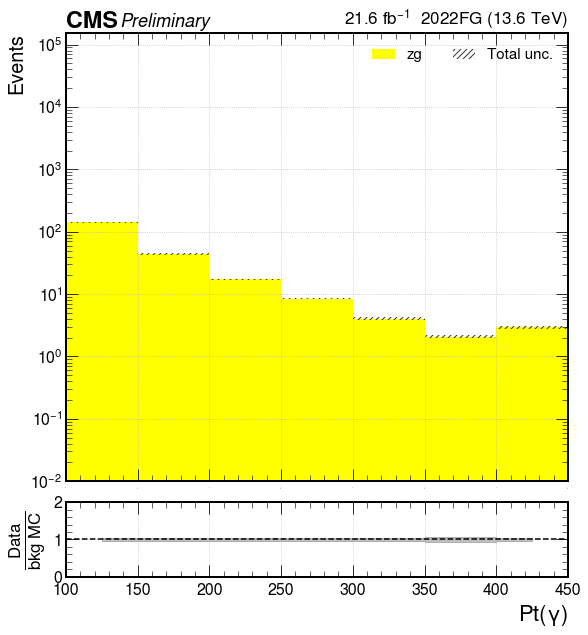

In [22]:
#tesing plot
arrays={
    # k: event_final_2[k]['muon_mass'] for k in event_final_2
   k: event_final_2[k]['reco_photon_pt'][:,0] for k in event_final_2 
}
# data_mc_compare_plot(arrays, weight=weight, plot_name='pt_gamma', x_name=r'$P_T \gamma$', x_max=111, x_min=71, bins=8, year='2022FG', density=True,overflow=True)
data_mc_compare_plot(arrays, weight=weight, plot_name='photon_pt', x_name=r'$Pt (\gamma)$', x_max=450, x_min=100, bins=7, year='2022FG', density=True,overflow=True)

### 保存root

In [23]:
#in fiducial
import boost_histogram as bh
import uproot
import numpy as np

# 设置bins，不包括underflow和overflow
# bins = [71, 76, 81,86,91,96,101,106,111]
bins = [0,50,100,150,200,250, 300, 350, 400, 450]
# bins = [0,450]
#250, 300, 350, 400, 450]
# 创建ROOT文件
with uproot.update("datacard.root") as f:
    
    zg_combined_data = []  # 存放所有zg样本的数据
    zg_combined_weights = []  # 存放所有zg样本的权重

    # 对于event_final_2中的每个key
    for key, values in event_final_2.items():
        if key == 'data':
            continue

        # 对于zg样本，将它们的数据和权重存储在列表中以便后续合并
        if key.startswith("zg"):
            # zg_combined_data.extend(values['muon_mass'])
            zg_combined_data.extend(values['reco_photon_pt'][:, 0])
            zg_combined_weights.extend(weight[key])
            continue

        # 将所有大于等于450的数据点都设置为450
        # data_to_fill = np.where(values['muon_mass'] >= 111, 110.9, values['muon_mass'])
        data_to_fill = np.where(values['reco_photon_pt'][:, 0] >= 450, 449.9, values['reco_photon_pt'][:, 0])
        
        # 创建boost_histogram直方图，并明确指定使用underflow和overflow bins
        hist = bh.Histogram(bh.axis.Regular(len(bins) - 1, bins[0], bins[-1], underflow=True, overflow=True))
        
        # 使用photon_pt和对应的权重填充直方图
        hist.fill(data_to_fill, weight=weight[key])
        
        # 将boost_histogram直方图转换为TH1并保存到ROOT文件中
        f[f"{key}_central_value"] = hist.to_numpy()
    
    # 对zg样本进行捏合并保存
    zg_combined_data = np.where(np.array(zg_combined_data) >= 450, 449.9, np.array(zg_combined_data))
    zg_hist = bh.Histogram(bh.axis.Regular(len(bins) - 1, bins[0], bins[-1], underflow=True, overflow=True))
    zg_hist.fill(zg_combined_data, weight=np.array(zg_combined_weights))
    f["zg_central_value"] = zg_hist.to_numpy()


In [35]:
#out_fiducial
import boost_histogram as bh
import uproot
import numpy as np

# 设置bins，不包括underflow和overflow
# bins = [71, 76, 81,86,91,96,101,106,111]
bins = [0,50,100,150,200,250, 300, 350, 400, 450]
# bins = [0,450]
#250, 300, 350, 400, 450]
# 创建ROOT文件
with uproot.update("datacard.root") as f:
    
    zg_combined_data = []  # 存放所有zg样本的数据
    zg_combined_weights = []  # 存放所有zg样本的权重

    # 对于event_final_2中的每个key
    for key, values in event_final_2.items():
        if key == 'data':
            continue

        # 对于zg样本，将它们的数据和权重存储在列表中以便后续合并
        if key.startswith("zg"):
            # zg_combined_data.extend(values['muon_mass'])
            zg_combined_data.extend(values['reco_outfiducial_photon_pt'][:, 0])
            zg_combined_weights.extend(weight[key])
            continue

        # 将所有大于等于450的数据点都设置为450
        # data_to_fill = np.where(values['muon_mass'] >= 111, 110.9, values['muon_mass'])
        data_to_fill = np.where(values['reco_outfiducial_photon_pt'][:, 0] >= 450, 449.9, values['reco_outfiducial_photon_pt'][:, 0])
        
        # 创建boost_histogram直方图，并明确指定使用underflow和overflow bins
        hist = bh.Histogram(bh.axis.Regular(len(bins) - 1, bins[0], bins[-1], underflow=True, overflow=True))
        
        # 使用photon_pt和对应的权重填充直方图
        hist.fill(data_to_fill, weight=weight[key])
        
        # 将boost_histogram直方图转换为TH1并保存到ROOT文件中
        f[f"{key}_central_value"] = hist.to_numpy()
    
    # 对zg样本进行捏合并保存
    zg_combined_data = np.where(np.array(zg_combined_data) >= 450, 449.9, np.array(zg_combined_data))
    zg_hist = bh.Histogram(bh.axis.Regular(len(bins) - 1, bins[0], bins[-1], underflow=True, overflow=True))
    zg_hist.fill(zg_combined_data, weight=np.array(zg_combined_weights))
    f["outfiducial_central_value"] = zg_hist.to_numpy()


## 出图

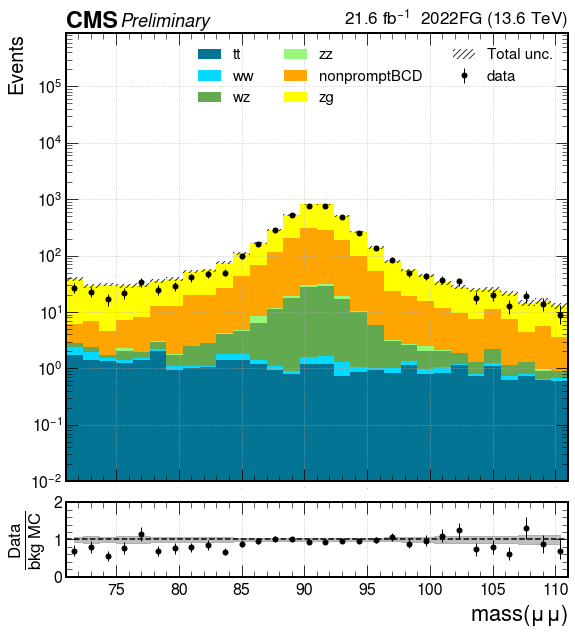

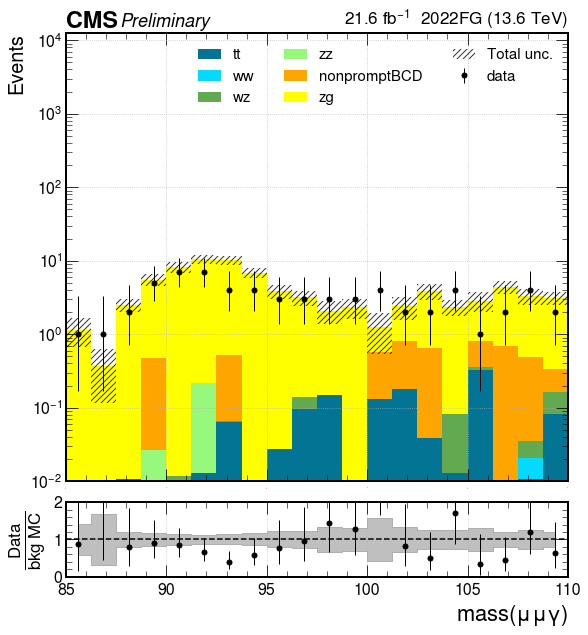

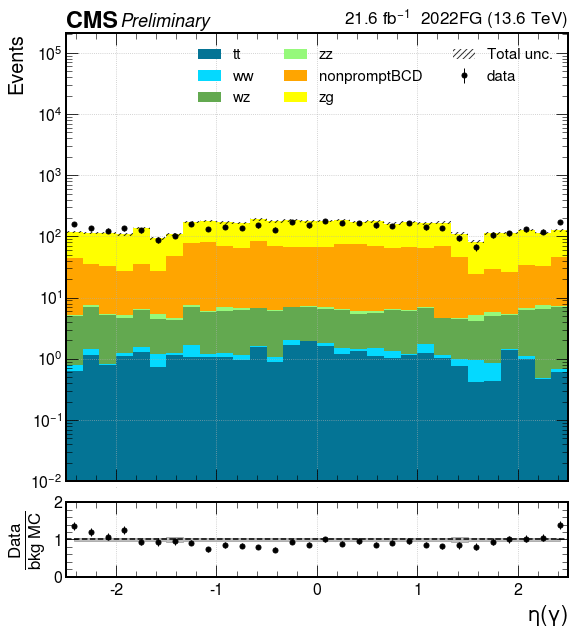

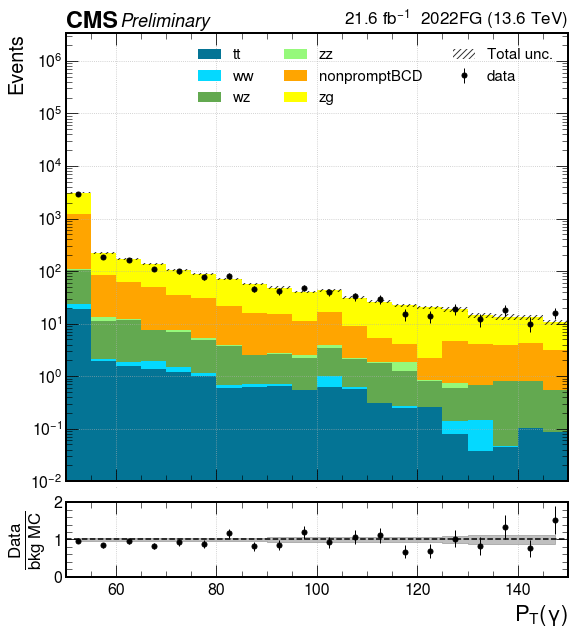

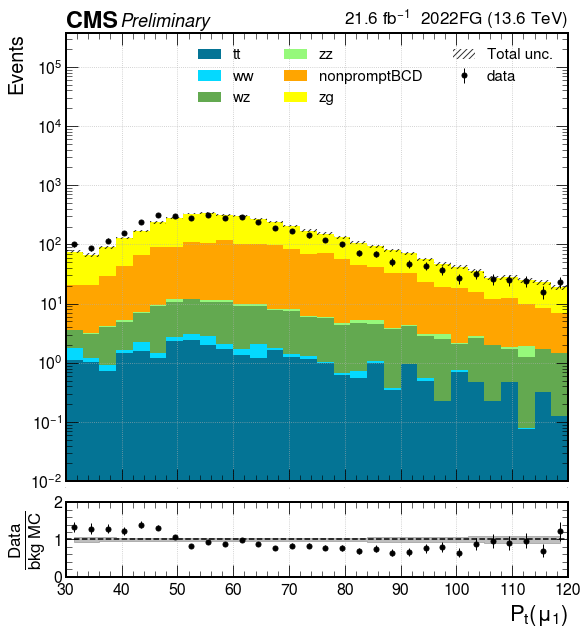

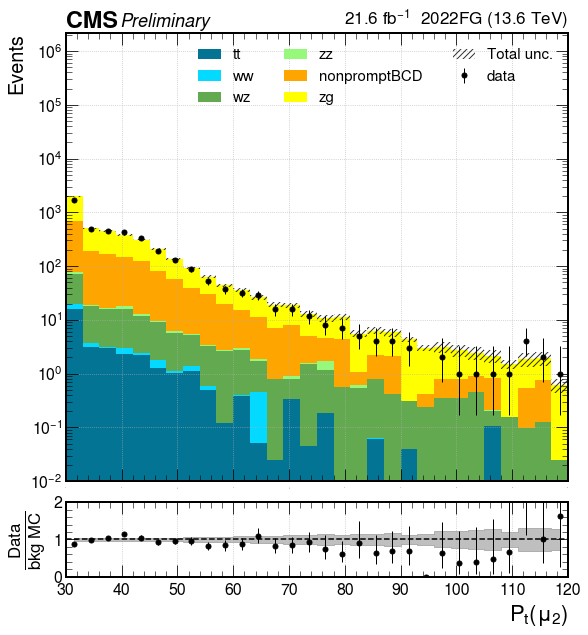

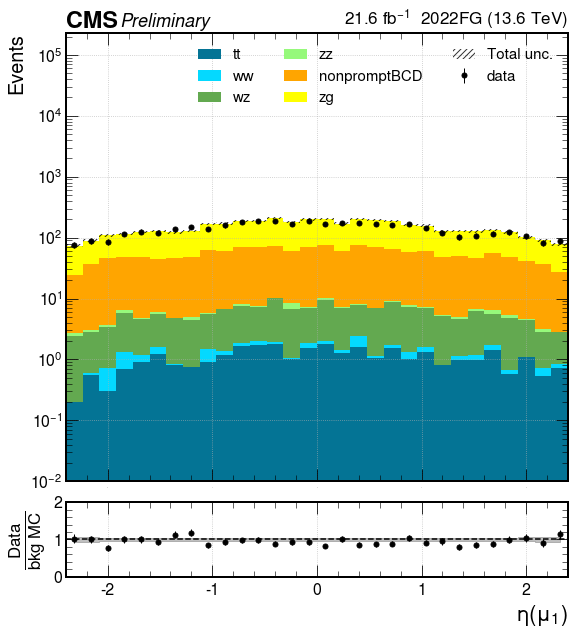

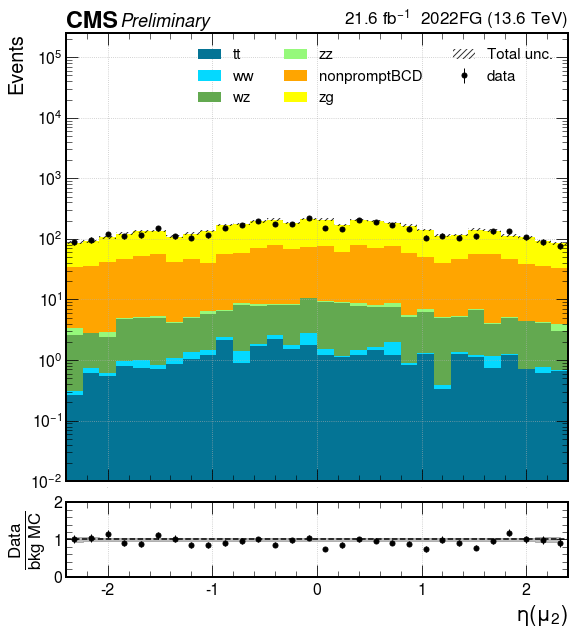

In [60]:
#plot all
plot_info = [
    ('muon_mass', r'$mass (\mu \mu)$', 'muon_mass', 71, 111, 30, False),
    ('gmumu_mass', r'$mass (\mu \mu \gamma)$', 'gmumu_mass', 85, 110, 20, False),
    ('photon_eta', r'$\eta (\gamma)$', 'photon_eta', -2.5, 2.5, 30, True),
    ('photon_pt', r'$P_T (\gamma)$', 'photon_pt', 50, 150, 20, True),
    ('muon1_pt', r'$P_t (\mu_1)$', 'muon1_pt', 30, 120, 30, False),
    ('muon2_pt', r'$P_t (\mu_2)$', 'muon2_pt', 30, 120, 30, False),
    ('muon1_eta', r'$\eta (\mu_1)$', 'muon1_eta', -2.4, 2.4, 30, False),
    ('muon2_eta', r'$\eta (\mu_2)$', 'muon2_eta', -2.4, 2.4, 30, False),
    # ('dr_lg',r'$\delta R(l\gamma)$','dr_lg',0.5, 1.5, 30, True)
]

for plot_name, x_name, var_name, x_min, x_max, bins, is_photon in plot_info:
    arrays = {k: event_final_2[k][var_name] for k in event_final_2}
    if is_photon:
        arrays = {k: v[:, 0] for k, v in arrays.items()}
    
    data_mc_compare_plot(arrays, weight=weight, plot_name=plot_name, x_name=x_name, x_min=x_min, x_max=x_max, bins=bins, year='2022FG', density=True, underflow=True,overflow=False)


## FSR

/tmp/ipykernel_1941593/1032871220.py:16: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cmap.set_under('white')


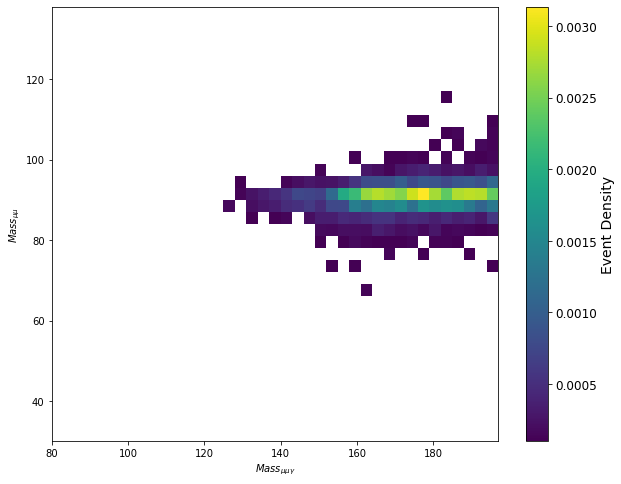

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

# 创建二维直方图
plt.figure(figsize=(10, 8))

# 使用归一化的方式
#counts, xedges, yedges, im = plt.hist2d(event_final['data']['gmumu_mass'],event_final['data']['muon_mass'], 
counts, xedges, yedges, im = plt.hist2d(event_final['zg1']['gmumu_mass'],event_final['zg1']['muon_mass'], 
                                        bins=[np.arange(80, 200, 3), np.arange(30, 140, 3)], 
                                        cmap='viridis', density=True)

# 创建一个新的colormap，将密度为0的部分设为白色
cmap = plt.cm.viridis
cmap.set_under('white')

# 使用新的colormap
im.set_cmap(cmap)

# 为图像设置最小可见值（小于这个值的部分将被cmap的set_under方法影响）
im.set_clim(0.0001)

# 显示色标
cbar = plt.colorbar(im, label='Event Density')
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Event Density', size=14)

plt.xlabel('$Mass_{\mu\mu\gamma}$')
plt.ylabel('$Mass_{\mu\mu}$')

plt.show()


/tmp/ipykernel_205944/4262816858.py:18: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cmap.set_under('white')


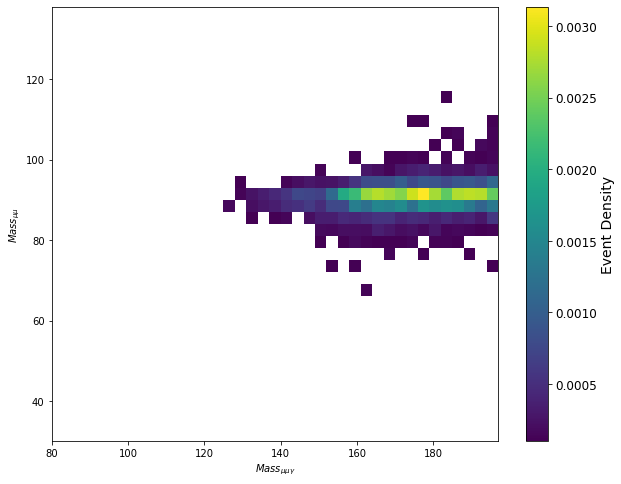

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

# 创建一个布尔数组，其中满足条件的位置是True，不满足的是False
mask = ak.any(event_final['zg1']['pdgid']==22,axis=1)

# 创建二维直方图
plt.figure(figsize=(10, 8))

# 使用归一化的方式
counts, xedges, yedges, im = plt.hist2d(event_final['zg1']['gmumu_mass'][mask], event_final['zg1']['muon_mass'][mask], 
                                        bins=[np.arange(80, 200, 3), np.arange(30, 140, 3)], 
                                        cmap='viridis', density=True)

# 创建一个新的colormap，将密度为0的部分设为白色
cmap = plt.cm.viridis
cmap.set_under('white')

# 使用新的colormap
im.set_cmap(cmap)

# 为图像设置最小可见值（小于这个值的部分将被cmap的set_under方法影响）
im.set_clim(0.0001)

# 显示色标
cbar = plt.colorbar(im, label='Event Density')
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Event Density', size=14)

plt.xlabel('$Mass_{\mu\mu\gamma}$')
plt.ylabel('$Mass_{\mu\mu}$')

plt.show()


/tmp/ipykernel_1941593/1747067208.py:36: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cmap.set_under('white')


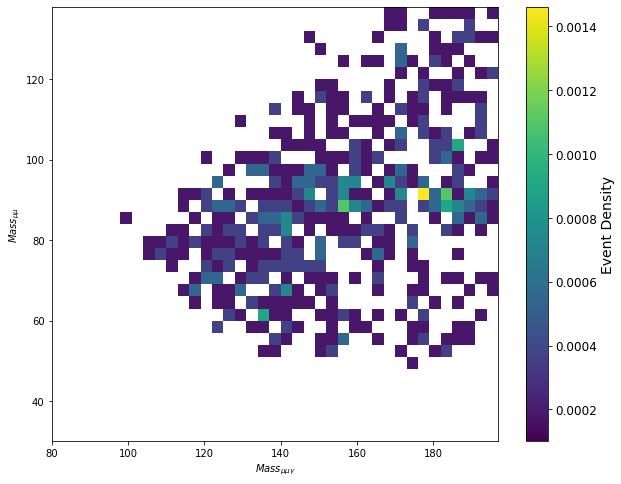

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import awkward as ak

# 创建二维直方图
plt.figure(figsize=(10, 8))

# 待绘制的样本列表
keys_to_plot = ['zg1', 'zg2', 'zg3', 'tt', 'zz', 'ww', 'wz']

# 初始化两个空的列表，用于存放所有样本的gmumu_mass和muon_mass数据
all_gmumu_mass = []
all_muon_mass = []

for key in keys_to_plot:
    current_data = event_final[key]
    
    pdg_ids = current_data['pdgid'][current_data['MotherIdx'][current_data['photonIdx']]]
    mask = (np.abs(pdg_ids) == 11) | (np.abs(pdg_ids) == 13)
    test = ak.flatten(mask)
    
    gmumu_mass = ak.to_numpy(current_data['gmumu_mass'][test])
    muon_mass = ak.to_numpy(current_data['muon_mass'][test])
    
    all_gmumu_mass.extend(gmumu_mass)
    all_muon_mass.extend(muon_mass)

# 使用归一化的方式绘制所有样本的数据
counts, xedges, yedges, im = plt.hist2d(all_gmumu_mass, all_muon_mass, 
                                        bins=[np.arange(80, 200, 3), np.arange(30, 140, 3)], 
                                        cmap='viridis', density=True)

# 创建一个新的colormap，将密度为0的部分设为白色
cmap = plt.cm.viridis
cmap.set_under('white')

# 使用新的colormap
im.set_cmap(cmap)

# 为图像设置最小可见值（小于这个值的部分将被cmap的set_under方法影响）
im.set_clim(0.0001)

# 显示色标
cbar = plt.colorbar(im, label='Event Density')
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Event Density', size=14)

plt.xlabel('$Mass_{\mu\mu\gamma}$')
plt.ylabel('$Mass_{\mu\mu}$')

plt.show()
